## 機械学習を使って株価を予測してみよう

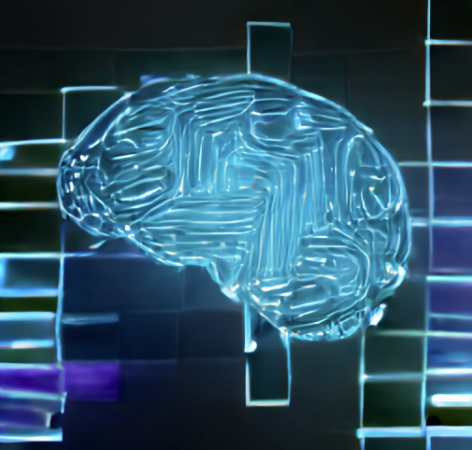

■ 問1　機械学習モデルを作るための環境を構築しよう。

仮想環境の構築

In [63]:
## macの場合

## python3 -m venv kino_env
## source kno_env/bin/activate

ライブラリ、モジュールのインストール

In [64]:
## pip install --upgrade pip
## pip install -r dataset/requirements.txt

ライブラリ、モジュールの読み込み

In [65]:
import pandas as pd
import numpy as np
import yfinance as yf

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima.model import ARIMA

from lightgbm import LGBMRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

import matplotlib.pyplot as plt
%matplotlib inline

■ 問2 データの取得と前処理を行いましょう。

In [66]:
# 株価データの取得

num = '9984.T'
start = '2015-1-1'
end = '2023-4-1'

df = yf.download(num, start=start, end=end)

[*********************100%***********************]  1 of 1 completed


In [67]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-05,3592.0,3622.5,3553.5,3580.5,3379.128174,12466800
2015-01-06,3518.5,3533.0,3497.5,3504.5,3307.403320,17874200
2015-01-07,3500.0,3570.5,3500.0,3533.0,3334.299805,14975000
2015-01-08,3593.0,3593.0,3543.5,3571.0,3370.163086,13534400
2015-01-09,3585.0,3610.5,3581.5,3602.0,3399.419189,16036000


In [68]:
df.tail() 

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-27,4990.0,5004.0,4942.0,4957.0,4935.987793,5869700
2023-03-28,4992.0,4993.0,4831.0,4888.0,4867.280273,9577800
2023-03-29,5088.0,5205.0,5050.0,5190.0,5168.000000,17838400
2023-03-30,5190.0,5218.0,5035.0,5084.0,5084.000000,13158900
2023-03-31,5137.0,5298.0,5111.0,5182.0,5182.000000,17111600


In [69]:
df.shape 

(2035, 6)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2035 entries, 2015-01-05 to 2023-03-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2035 non-null   float64
 1   High       2035 non-null   float64
 2   Low        2035 non-null   float64
 3   Close      2035 non-null   float64
 4   Adj Close  2035 non-null   float64
 5   Volume     2035 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 111.3 KB


In [71]:
df.isnull().sum()


Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [72]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.000000,2.035000e+03
mean,4934.155037,4997.528010,4873.559951,4933.275184,4797.017291,1.541587e+07
std,1563.270254,1587.437081,1541.264666,1562.356397,1573.731932,9.463548e+06
min,2170.000000,2220.000000,2066.500000,2082.000000,1977.262817,0.000000e+00
25%,3876.500000,3913.000000,3823.250000,3875.750000,3718.268555,9.830200e+06
50%,4642.000000,4690.000000,4593.500000,4635.500000,4483.430176,1.312480e+07
75%,5569.500000,5645.000000,5491.250000,5562.500000,5496.748291,1.807710e+07
max,10625.000000,10695.000000,10440.000000,10635.000000,10441.175781,1.547452e+08


■ 問3　特徴量を生成しましょう

特徴量生成は、機械学習でデータを扱う際に使われる大切なステップです。

例えば、野球の試合で選手の成績を分析する場合を考えましょう。選手の特徴を表すために、打率やホームラン数などが使われます。これらの成績は、特徴量として利用されます。

特徴量生成では、成績以外のデータからも有用な情報を引き出すことができます。例えば、選手の身長や体重は、プレーにどのような影響を与えるかを示す特徴量となります。また、選手の経験年数や守るポジションも特徴量として利用できます。

さらに、特徴量生成では複数の特徴量を組み合わせて新たな特徴量を作ることもできます。例えば、選手の打率とホームラン数を組み合わせて「打率に比べて多くのホームランを打つ選手」という特徴量を作ることができます。

特徴量生成の目的は、データから意味のある情報を取り出し、機械学習モデルがその情報を理解しやすくすることです。適切な特徴量を生成することで、モデルの予測精度を向上させることができます。

特徴量生成は機械学習において重要なステップであり、データの情報をうまく表現するために工夫が必要です。中学生でも理解しやすい例として、野球の選手の成績や特徴を考えることで、特徴量生成について理解することができるでしょう。

In [73]:
## 5日、25日、50日の移動平均線を作成しましょう。変数dfの新しい列を3つ追加しましょう。

df['MA5'] = df['Adj Close'].rolling(5).mean()
df['MA25'] = df['Adj Close'].rolling(25).mean()
df['MA50'] = df['Adj Close'].rolling(50).mean()

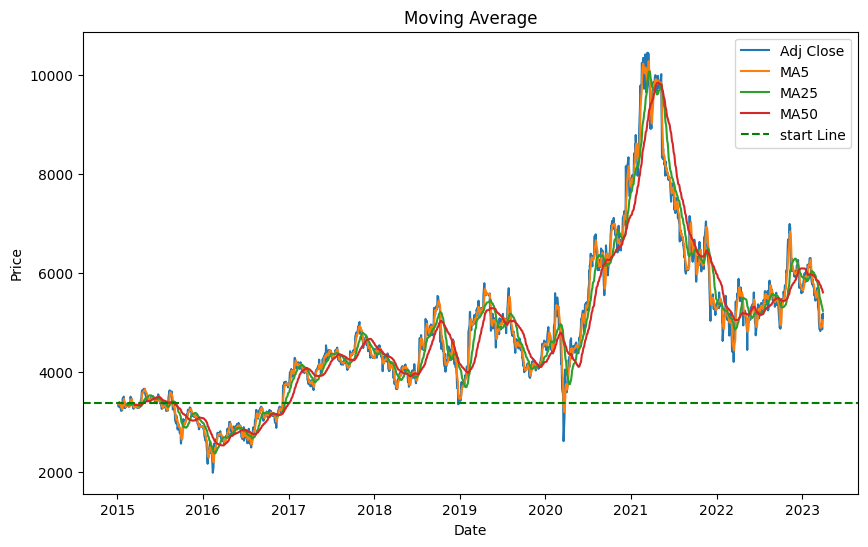

In [74]:
# グラフのプロット
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Adj Close'], label='Adj Close')
plt.plot(df.index, df['MA5'], label='MA5')
plt.plot(df.index, df['MA25'], label='MA25')
plt.plot(df.index, df['MA50'], label='MA50')

# 横線の追加
plt.axhline(y=df['Adj Close'][0], color='g', linestyle='--', label='start Line')

plt.title('Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [75]:
## 5日、25日、50日の指数平滑移動平均線を作成しましょう。変数dfの新しい列を3つ追加しましょう。

df['EMA5'] = df['Close'].ewm(span=5, adjust=False).mean()
df['EMA25'] = df['Close'].ewm(span=25, adjust=False).mean()
df['EMA50'] = df['Close'].ewm(span=50, adjust=False).mean()

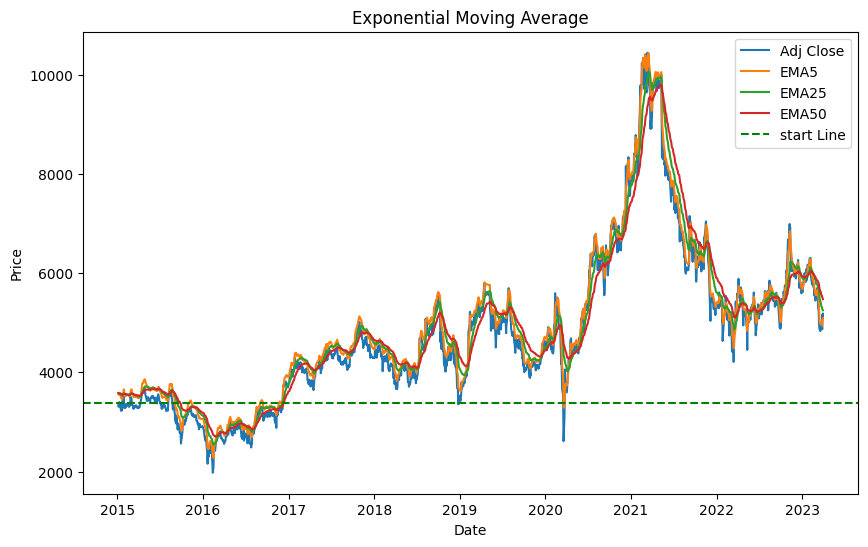

In [76]:
# グラフのプロット
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Adj Close'], label='Adj Close')
plt.plot(df.index, df['EMA5'], label='EMA5')
plt.plot(df.index, df['EMA25'], label='EMA25')
plt.plot(df.index, df['EMA50'], label='EMA50')

# 横線の追加
plt.axhline(y=df['Adj Close'][0], color='g', linestyle='--', label='start Line')

plt.title('Exponential Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [77]:
## 5日、25日、50日の価格変化率を算出しましょう。df['Price_Change_Rate_5'],df['Price_Change_Rate_25'],df['Price_Change_Rate_50']

# 移動平均の期間を指定
ma_list = [5, 25, 50]

# 価格変化率を計算する関数
def price_change_rate(data, n):
    return (df['Adj Close'] - df['Adj Close'].shift(n)) / df['Adj Close'].shift(n)

# 5日、25日、50日の価格変化率を計算
for ma in ma_list:
    df[f"Price_Change_Rate_{ma}"] = price_change_rate(df, ma)

In [78]:
df.iloc[:, -3:]

,Price_Change_Rate_5,Price_Change_Rate_25,Price_Change_Rate_50
Date,,,
2015-01-05,NaN,NaN,NaN
2015-01-06,NaN,NaN,NaN
2015-01-07,NaN,NaN,NaN
2015-01-08,NaN,NaN,NaN
2015-01-09,NaN,NaN,NaN
...,...,...,...
2023-03-27,0.013494,-0.158832,-0.177125
2023-03-28,0.007627,-0.151978,-0.174882
2023-03-29,0.040706,-0.094083,-0.112213


In [79]:
# 25日のボリンジャーバンドを作成しましょう。標準偏差は2σです。df['2upper']、df['2lower']
# 移動平均線
df['SMA'] = df['Adj Close'].rolling(10).mean()

#　ボリンジャーばバンド
df['STD'] = df['Adj Close'].rolling(10).std()
df['Upper'] = df['SMA'] + 2 * df['STD']
df['Lower'] = df['SMA'] - 2 * df['STD']

In [80]:
!pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [81]:
# 5日、25日、50日のRSIを作成しましょう。df['RSI_5'], df['RSI_25'], df['RSI_50']

import ta

df['RSI_5'] = ta.momentum.RSIIndicator(df['Adj Close'], window=5).rsi()
df['RSI_25'] = ta.momentum.RSIIndicator(df['Adj Close'], window=25).rsi()
df['RSI_50'] = ta.momentum.RSIIndicator(df['Adj Close'], window=50).rsi()

In [82]:
# MACDを作成しましょう。df['MACD']

df['EMA12'] = df['Close'].ewm(span=12).mean()
df['EMA26'] = df['Close'].ewm(span=26).mean()
df['MACD'] = df['EMA12'] - df['EMA26']

In [83]:
# 変数df['Adj Close']とdf['Open']列の差分が「0以上を1、0未満を0」とし、陽線と陰線を作成しましょう。df['today_up_down']

df['today_up_down'] = df.apply(lambda x : 1 if (x['Adj Close'] - x['Open']) >= 0 else 0, axis=1)

In [84]:
# dfに欠損値がある場合、その行を補正もしくは削除しましょう。
df.isnull().sum()

Open                     0
High                     0
Low                      0
Close                    0
Adj Close                0
Volume                   0
MA5                      4
MA25                    24
MA50                    49
EMA5                     0
EMA25                    0
EMA50                    0
Price_Change_Rate_5      5
Price_Change_Rate_25    25
Price_Change_Rate_50    50
SMA                      9
STD                      9
Upper                    9
Lower                    9
RSI_5                    4
RSI_25                  24
RSI_50                  49
EMA12                    0
EMA26                    0
MACD                     0
today_up_down            0
dtype: int64

In [85]:
# 欠損値を含む行を削除
df = df.dropna()

df.isnull().sum()

Open                    0
High                    0
Low                     0
Close                   0
Adj Close               0
Volume                  0
MA5                     0
MA25                    0
MA50                    0
EMA5                    0
EMA25                   0
EMA50                   0
Price_Change_Rate_5     0
Price_Change_Rate_25    0
Price_Change_Rate_50    0
SMA                     0
STD                     0
Upper                   0
Lower                   0
RSI_5                   0
RSI_25                  0
RSI_50                  0
EMA12                   0
EMA26                   0
MACD                    0
today_up_down           0
dtype: int64

■ 問4　機械学習モデルで学習できるようにデータを整えましょう。

In [86]:
df.shape

(1985, 26)

In [87]:
# 削除する範囲を指定
start_date = pd.to_datetime('2022-09-01')
end_date = pd.to_datetime('2023-11-30')

# 指定した日付範囲のデータを削除
df = df.drop(df[(df.index>= start_date) & (df.index <= end_date)].index)

In [88]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,MA5,MA25,MA50,EMA5,...,STD,Upper,Lower,RSI_5,RSI_25,RSI_50,EMA12,EMA26,MACD,today_up_down
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-18,3497.5,3508.0,3472.0,3493.0,3296.549561,12264800,3304.477197,3347.550498,3345.596914,3499.364391,...,24.922391,3354.935578,3255.246013,37.928573,45.881434,47.009798,3517.564383,3535.654050,-18.089667,0
2015-03-19,3494.0,3553.0,3489.5,3516.0,3318.256836,18207200,3307.497363,3346.380244,3345.813984,3504.909594,...,21.307661,3345.016494,3259.785850,53.373293,47.713188,48.116585,3517.323668,3534.171087,-16.847418,0
2015-03-20,3518.0,3557.0,3499.5,3534.0,3335.244141,16173000,3311.555664,3346.569004,3345.832871,3514.606396,...,20.513723,3343.003886,3260.948995,62.500586,49.117102,48.967735,3519.889624,3534.158195,-14.268571,0
2015-03-23,3540.0,3562.5,3515.5,3530.0,3331.468750,12378400,3317.218213,3345.870645,3345.058984,3519.737597,...,22.551740,3349.675209,3259.468248,59.276989,48.813674,48.786231,3521.445255,3533.845277,-12.400022,0
2015-03-24,3510.5,3522.5,3490.0,3508.5,3311.177979,11102400,3318.539453,3345.040137,3343.294160,3515.991732,...,19.835793,3347.971147,3268.627974,44.023010,47.181884,47.814279,3519.453473,3531.940205,-12.486731,0


In [89]:
X = df.loc[:, ~df.columns.isin(['Adj Close'])]
Y = df['Adj Close']

In [90]:
X.head()

,Open,High,Low,Close,Volume,MA5,MA25,MA50,EMA5,EMA25,...,STD,Upper,Lower,RSI_5,RSI_25,RSI_50,EMA12,EMA26,MACD,today_up_down
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-18,3497.5,3508.0,3472.0,3493.0,12264800,3304.477197,3347.550498,3345.596914,3499.364391,3535.771455,...,24.922391,3354.935578,3255.246013,37.928573,45.881434,47.009798,3517.564383,3535.654050,-18.089667,0
2015-03-19,3494.0,3553.0,3489.5,3516.0,18207200,3307.497363,3346.380244,3345.813984,3504.909594,3534.250574,...,21.307661,3345.016494,3259.785850,53.373293,47.713188,48.116585,3517.323668,3534.171087,-16.847418,0
2015-03-20,3518.0,3557.0,3499.5,3534.0,16173000,3311.555664,3346.569004,3345.832871,3514.606396,3534.231299,...,20.513723,3343.003886,3260.948995,62.500586,49.117102,48.967735,3519.889624,3534.158195,-14.268571,0
2015-03-23,3540.0,3562.5,3515.5,3530.0,12378400,3317.218213,3345.870645,3345.058984,3519.737597,3533.905815,...,22.551740,3349.675209,3259.468248,59.276989,48.813674,48.786231,3521.445255,3533.845277,-12.400022,0
2015-03-24,3510.5,3522.5,3490.0,3508.5,11102400,3318.539453,3345.040137,3343.294160,3515.991732,3531.951521,...,19.835793,3347.971147,3268.627974,44.023010,47.181884,47.814279,3519.453473,3531.940205,-12.486731,0


In [91]:
Y.head()

Date
2015-03-18    3296.549561
2015-03-19    3318.256836
2015-03-20    3335.244141
2015-03-23    3331.468750
2015-03-24    3311.177979
Name: Adj Close, dtype: float64

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=False)

In [93]:
X_train.head()

,Open,High,Low,Close,Volume,MA5,MA25,MA50,EMA5,EMA25,...,STD,Upper,Lower,RSI_5,RSI_25,RSI_50,EMA12,EMA26,MACD,today_up_down
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-18,3497.5,3508.0,3472.0,3493.0,12264800,3304.477197,3347.550498,3345.596914,3499.364391,3535.771455,...,24.922391,3354.935578,3255.246013,37.928573,45.881434,47.009798,3517.564383,3535.654050,-18.089667,0
2015-03-19,3494.0,3553.0,3489.5,3516.0,18207200,3307.497363,3346.380244,3345.813984,3504.909594,3534.250574,...,21.307661,3345.016494,3259.785850,53.373293,47.713188,48.116585,3517.323668,3534.171087,-16.847418,0
2015-03-20,3518.0,3557.0,3499.5,3534.0,16173000,3311.555664,3346.569004,3345.832871,3514.606396,3534.231299,...,20.513723,3343.003886,3260.948995,62.500586,49.117102,48.967735,3519.889624,3534.158195,-14.268571,0
2015-03-23,3540.0,3562.5,3515.5,3530.0,12378400,3317.218213,3345.870645,3345.058984,3519.737597,3533.905815,...,22.551740,3349.675209,3259.468248,59.276989,48.813674,48.786231,3521.445255,3533.845277,-12.400022,0
2015-03-24,3510.5,3522.5,3490.0,3508.5,11102400,3318.539453,3345.040137,3343.294160,3515.991732,3531.951521,...,19.835793,3347.971147,3268.627974,44.023010,47.181884,47.814279,3519.453473,3531.940205,-12.486731,0


In [94]:
y_train.head()

Date
2015-03-18    3296.549561
2015-03-19    3318.256836
2015-03-20    3335.244141
2015-03-23    3331.468750
2015-03-24    3311.177979
Name: Adj Close, dtype: float64

In [95]:
X_test.head()

,Open,High,Low,Close,Volume,MA5,MA25,MA50,EMA5,EMA25,...,STD,Upper,Lower,RSI_5,RSI_25,RSI_50,EMA12,EMA26,MACD,today_up_down
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-02,10625.0,10665.0,10360.0,10380.0,9830000,10025.295898,9348.892441,8726.761328,10287.124697,9673.509196,...,200.506318,10523.307754,9721.282480,57.589727,63.413057,62.400660,10110.020513,9642.781019,467.239494,0
2021-03-03,10415.0,10600.0,10365.0,10600.0,8915700,10146.643164,9424.921035,8777.224551,10391.416465,9744.777719,...,218.080571,10576.128232,9703.805948,64.327591,64.975923,63.330565,10185.401972,9713.686129,471.715844,0
2021-03-04,10285.0,10300.0,9935.0,10050.0,16723400,10084.791211,9479.311387,8810.604863,10277.610977,9768.256356,...,232.091837,10569.297638,9640.930291,42.985927,58.471491,59.572058,10164.570900,9738.598267,425.972632,0
2021-03-05,9750.0,10070.0,9660.0,10055.0,17646400,10116.208008,9536.686309,8844.004844,10203.407318,9790.313560,...,242.504228,10562.141952,9592.125040,43.200079,58.510824,59.594304,10147.713838,9762.035433,385.678406,1
2021-03-08,10180.0,10195.0,9763.0,9818.0,16223200,9995.057031,9596.888730,8870.100410,10074.938212,9792.443286,...,276.245122,10577.393272,9472.412782,35.336421,55.896997,58.049426,10096.988632,9766.180956,330.807676,0


■ 問5　5つの機械学習モデルを構築し予測をしましょう。

決定木は、問題解決や予測を行うための機械学習モデルです。

イメージすると、冒険の途中で「はい」「いいえ」の質問を連続してするゲームに似ています。例えば、果物の種類を当てる場合、「それは赤いですか？」と質問すると、「はい」と答えるか「いいえ」と答えるかを選びます。その答えによって、次にどの質問をするかが決まります。

決定木では、データの特徴（例：果物の色、形、大きさなど）を利用して質問をしていきます。データを分類するための「分岐点」を見つけることが目標です。例えば、果物の色が「赤い」かどうかで分岐し、次に形状を判断するといった具合です。

このように質問と分岐を繰り返すことで、最終的にはデータを分類する決定木ができます。そして、新しいデータが与えられたときに、この決定木を使って予測や判断を行うことができます。

決定木はシンプルで理解しやすいモデルですが、適切な質問や分岐を見つけることが重要です。また、データの特徴や質問の順序を適切に設定することで、より精度の高い予測を行うことができます。

これが決定木モデルの基本的な説明です。もちろん、実際の機械学習ではもっと複雑なデータや処理が行われますが、中学生でもこのように理解していただけると思います。

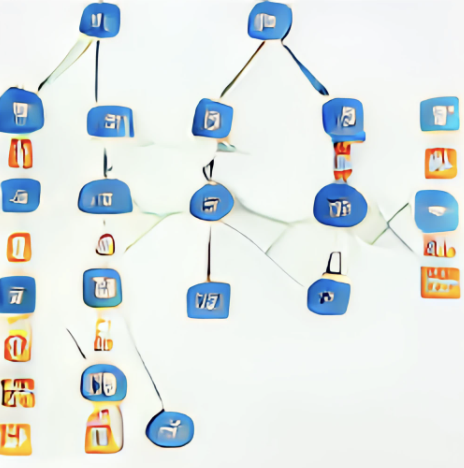

In [96]:
from sklearn.tree import DecisionTreeRegressor

# 決定木モデルの構築
model = DecisionTreeRegressor(max_depth=5)
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5)

In [97]:
import numpy as np
from sklearn.metrics import mean_squared_error

# 予測とバックテスト
y_pred = model.predict(X_test)

score = np.sqrt(mean_squared_error(y_test, y_pred))
# print(score)
print(f'RMSE: {score:.2f}')

RMSE: 693.06


In [98]:
df_score = dict()  # 空の辞書型を作成
# キーと値を順番に追加
df_score['決定木'] = score

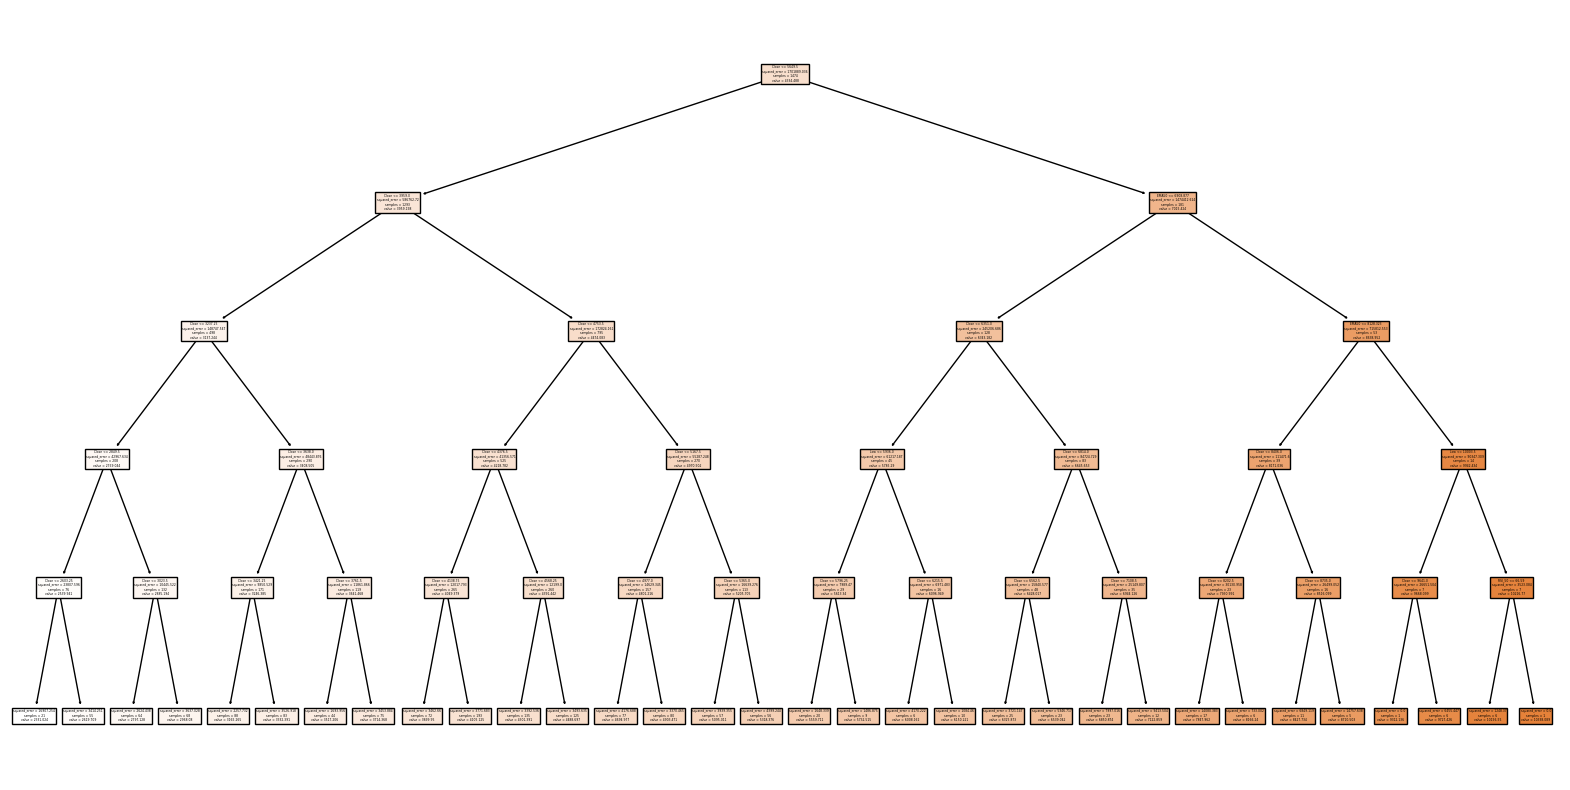

1. Close: 0.9068
2. EMA50: 0.0918
3. Low: 0.0014
4. RSI_50: 0.0000
5. today_up_down: 0.0000
6. Price_Change_Rate_5: 0.0000
7. High: 0.0000
8. Volume: 0.0000
9. MA5: 0.0000
10. MA25: 0.0000
11. MA50: 0.0000
12. EMA5: 0.0000
13. EMA25: 0.0000
14. Price_Change_Rate_25: 0.0000
15. MACD: 0.0000
16. Price_Change_Rate_50: 0.0000
17. SMA: 0.0000
18. STD: 0.0000
19. Upper: 0.0000
20. Lower: 0.0000
21. RSI_5: 0.0000
22. RSI_25: 0.0000
23. EMA12: 0.0000
24. EMA26: 0.0000
25. Open: 0.0000


In [99]:
# 決定木の可視化
plt.figure(figsize=(20, 10))
plot_tree(model, filled=True, feature_names=X.columns)
plt.show()

# 特徴量の重要度の出力
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print(f'{f + 1}. {X_train.columns[indices[f]]}: {importances[indices[f]]:.4f}')

回帰モデルは、機械学習の一種であり、データの中で数値の予測を行うモデルです。

イメージすると、お小遣いをもらうために「1週間にどれくらい家事をしたか」や「テストの点数」などの情報を使って予測するゲームに似ています。これを回帰モデルで解決します。

回帰モデルでは、データの中で関係があると思われる要素（例：勉強時間、テストの難易度）と結果（例：点数）を使って学習します。学習を通じて、要素と結果の関係を数学的に表現する数式（モデル）を作成します。

このモデルを使って、新たなデータが与えられたときに予測を行います。例えば、勉強時間が3時間だった場合、回帰モデルはその時間に対応する点数を予測します。

回帰モデルは、直線や曲線の形で関係を表現します。直線の場合は単回帰モデル、曲線の場合は重回帰モデルなどがあります。

回帰モデルは、数値の予測が必要な場面で活用されます。例えば、将来の株価や不動産価格、人々の身長と体重の関係など、数値の予測が求められる問題に適用されます。

RMSE: 14.66


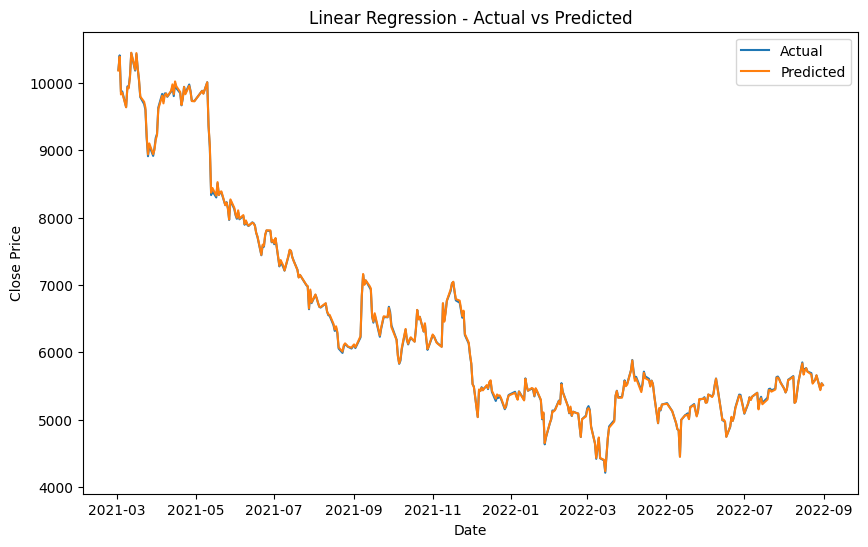

In [100]:
# モデルの学習
# 線形回帰モデルの構築とトレーニング
from sklearn.linear_model import LinearRegression

X = df.loc[:, ~df.columns.isin(['Adj Close'])]
Y = df['Adj Close']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

# テストデータに対する予測
y_pred = model.predict(X_test)
score = np.sqrt(mean_squared_error(y_test, y_pred))
# print(score)
print(f'RMSE: {score:.2f}')

# 予測結果の可視化
plt.figure(figsize=(10, 6))
plt.plot(X_test.index, y_test, label='Actual')
plt.plot(X_test.index, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Linear Regression - Actual vs Predicted')
plt.legend()
plt.show()

In [101]:
df_score['回帰'] = score

ARIMAモデルは、機械学習の一種であり、時間の変動パターンを予測するためのモデルです。

イメージすると、天気予報で「明日の気温はどのくらいになるか」と予測するゲームに似ています。これをARIMAモデルで解決します。

ARIMAモデルは、過去のデータを使って将来の値を予測します。具体的には、時系列データ（例：気温の変動）の中で規則性やパターンを見つけ出し、それを数学的なモデルで表現します。

ARIMAモデルは、3つの要素から構成されています。まず、「AR (AutoRegressive)」は、直前の値の影響を受けることを意味します。次に、「I (Integrated)」は、差分をとる操作でデータを安定化させます。最後に、「MA (Moving Average)」は、過去の誤差の影響を考慮します。

ARIMAモデルでは、これらの要素を組み合わせて、時間の変動パターンを表現する数式を作成します。この数式を使って、将来の値を予測します。例えば、過去の気温データからARIMAモデルを学習させることで、明日の気温を予測することができます。

ARIMAモデルは、時系列データの予測に広く利用されます。例えば、株価の変動や需要予測など、時間に依存するデータの予測に適しています。

In [102]:
from statsmodels.tsa.arima.model import ARIMA

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=False)

# モデルの構築とトレーニング
p, d, q = 1, 1, 1  # 適切な次数を設定する
model = ARIMA(y_train, order=(p, d, q), exog=X_train)
results = model.fit()

# 予測
start_index = len(X_train)
end_index = len(X_train) + len(X_test) - 1
y_pred = results.predict(start=start_index, end=end_index, exog=X_test)


# RMSEの計算
score = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", score)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE: 19.713275507444628


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


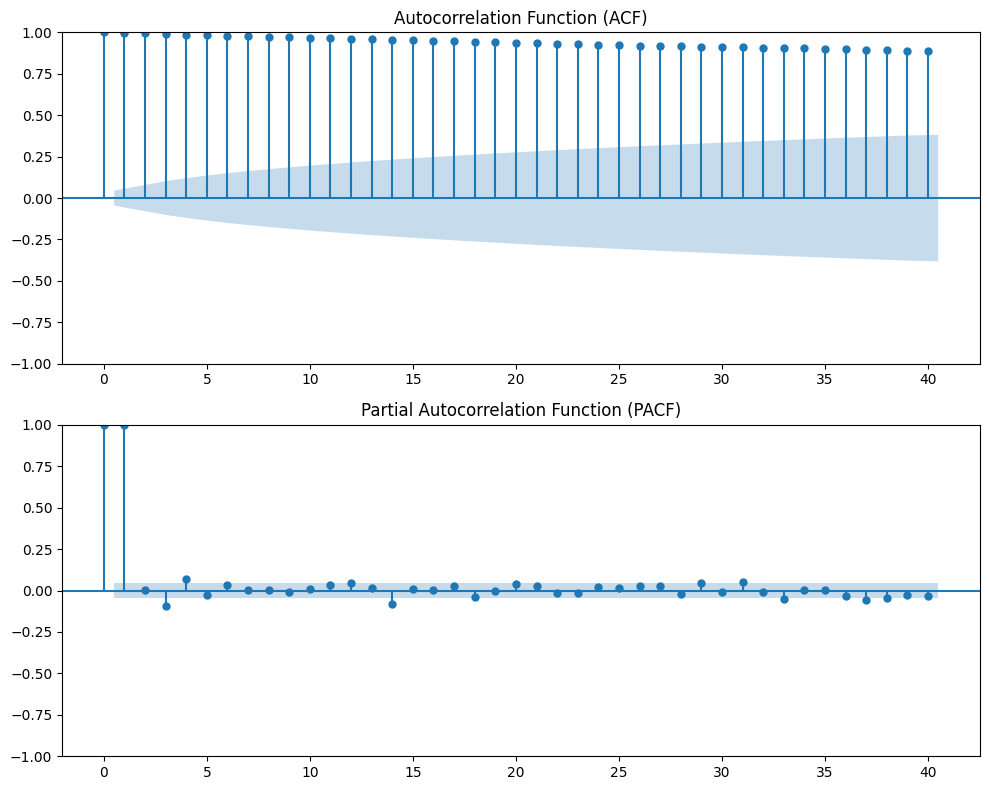

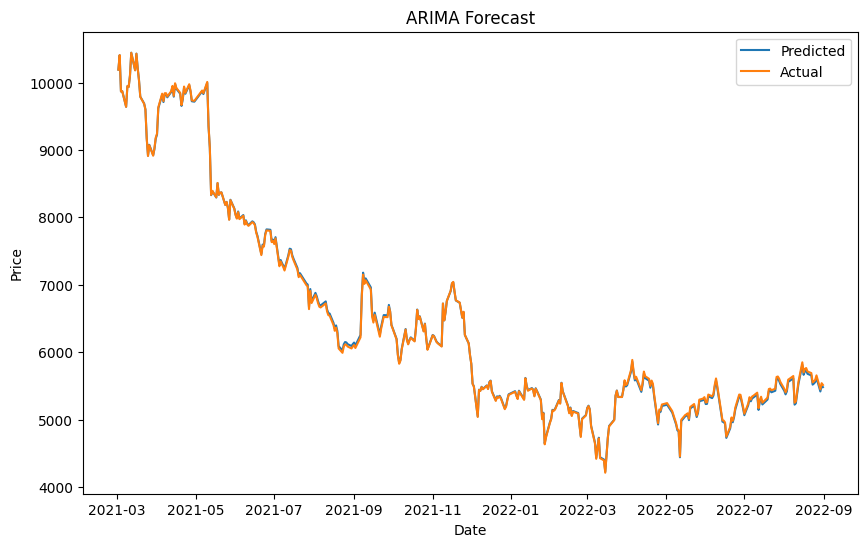

In [103]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# 予測結果と実測値の表示
y_pred.index = X_test.index
predictions = pd.Series(y_pred, index=X_test.index)
actual = y_test

# ACFとPACFの計算と可視化
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# ACFの可視化
plot_acf(Y, ax=axes[0], lags=40)
axes[0].set_title('Autocorrelation Function (ACF)')

# PACFの可視化
plot_pacf(Y, ax=axes[1], lags=40)
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()

# プロット
plt.figure(figsize=(10, 6))
plt.plot(predictions, label='Predicted')
plt.plot(actual, label='Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

In [104]:
df_score['ARIMA'] = score

LightGBMモデルは、機械学習の一種であり、高速かつ高性能な勾配ブースティング木モデルです。

イメージすると、クイズ大会で「問題の難易度や前の問題の正解率など」を考慮して次の問題を出題するゲームに似ています。これをLightGBMモデルで解決します。

LightGBMモデルは、たくさんの小さな決定木を組み合わせて予測を行います。各決定木は、データの特徴（例：問題の難易度、前の問題の正解率）に基づいて分類や回帰を行います。

モデルの学習では、データから正解となる目標値を持つ問題（例：クイズの正解）を学習させます。LightGBMモデルは、モデルの予測と正解の差（誤差）を最小化するように学習を進めます。

多くのデータや特徴量を扱う場合でも高速に処理できるため、大規模なデータセットに適しています。

また、LightGBMモデルは、特徴量の重要度を評価することもできます。重要な特徴量を抽出することで、問題解決や予測に寄与する要素を明らかにすることができます。

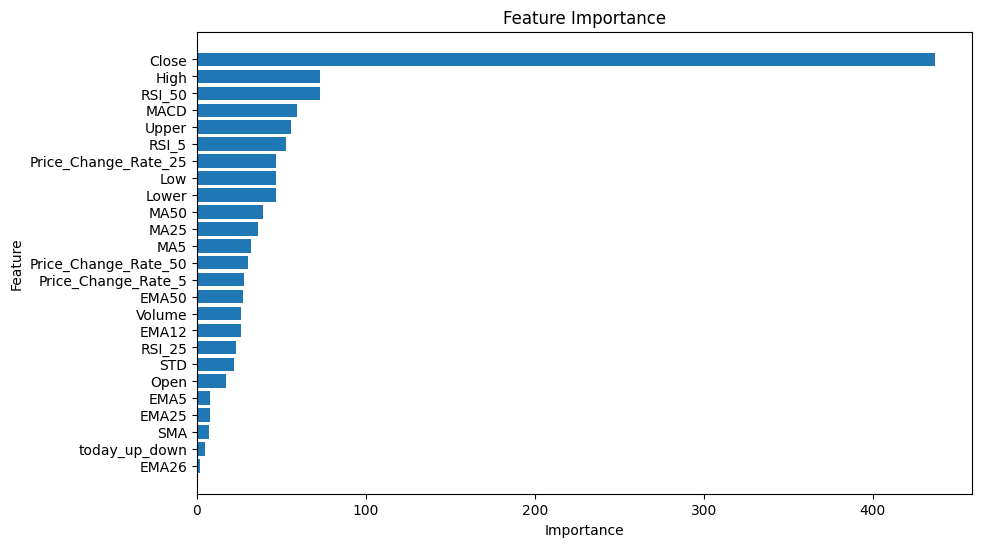

In [105]:
from lightgbm import LGBMRegressor
from lightgbm import plot_importance

# 特徴量とターゲットの抽出
X = df.loc[:, ~df.columns.isin(['Adj Close'])]
X_columns = X.columns
X = X.values
Y = df['Adj Close']
Y = Y.values

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=False)

# LGBMRegressorモデルの構築とトレーニング
model = LGBMRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
model.fit(X_train, y_train)

# 予測
y_pred = model.predict(X_test)

# 特徴量の重要度を取得
feature_importance = model.feature_importances_

# 特徴量の重要度をデータフレームとして作成
df_importance = pd.DataFrame({'Feature': X_columns, 'Importance': feature_importance})
df_importance = df_importance.sort_values('Importance', ascending=True)

# 特徴量の重要度の可視化
plt.figure(figsize=(10, 6))
plt.barh(df_importance['Feature'], df_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [106]:
# RMSEの計算
score = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", score)

RMSE: 213.58062654106826


In [107]:
df_score['LGBM'] = score

CNN（Convolutional Neural Network）モデルは、機械学習の一種であり、ファイナンス分析にも利用されるモデルです。

イメージすると、株価の変動や経済指標の影響を考慮しながら、株式の将来の動向を予測するゲームに似ています。これをCNNモデルで解決します。

CNNモデルは、データの中でパターンや特徴を抽出するための層（畳み込み層）を使用します。ファイナンス分析では、株価の変動や財務指標のパターンを抽出するために畳み込み層が使用されます。

例えば、畳み込み層は、株価の変動パターンや経済指標の変動に対して敏感に反応し、それらの特徴を捉えます。これにより、株価の予測やトレンドの分析に役立つ情報を抽出することができます。

また、畳み込み層の他にプーリング層や全結合層も使用されます。プーリング層はデータを圧縮して情報を集約し、全結合層は抽出された特徴を元に予測や分類を行います。

Epoch 1/10
47/47 [==============================] - 2s 4ms/step - loss: 209284186112.0000
Epoch 2/10
47/47 [==============================] - 0s 6ms/step - loss: 653272128.0000
Epoch 3/10
47/47 [==============================] - 0s 7ms/step - loss: 8510849.0000
Epoch 4/10
47/47 [==============================] - 0s 7ms/step - loss: 3809647.5000
Epoch 5/10
47/47 [==============================] - 0s 5ms/step - loss: 2736423.5000
Epoch 6/10
47/47 [==============================] - 0s 5ms/step - loss: 4151159.5000
Epoch 7/10
47/47 [==============================] - 0s 5ms/step - loss: 2700539.0000
Epoch 8/10
47/47 [==============================] - 0s 5ms/step - loss: 2617351.2500
Epoch 9/10
47/47 [==============================] - 0s 7ms/step - loss: 3572231.0000
Epoch 10/10
12/12 [==============================] - 0s 8ms/step
              Predicted        Actual
Date                                 
2021-03-02  6837.691895  10190.823242
2021-03-03  6793.285645  10406.813477
2021-03-04 

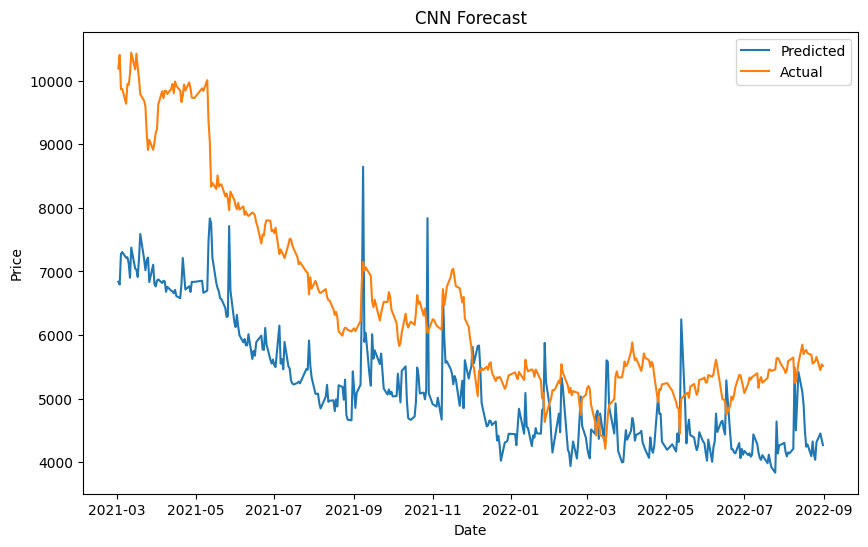

In [108]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# 特徴量とターゲットの抽出
X = df.loc[:, ~df.columns.isin(['Adj Close'])]
X = X.values
Y = df['Adj Close']
Y = Y.values

# データの前処理
X = X.reshape(X.shape[0], X.shape[1], 1)  # 3Dテンソルに変換

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=False)

# CNNモデルの構築
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

# モデルのコンパイル
model.compile(optimizer='adam', loss='mean_squared_error')

# モデルのトレーニング
model.fit(X_train, y_train, epochs=10, batch_size=32)

# 予測
y_pred = model.predict(X_test)

# 予測結果と実測値の表示
df_y_pred = pd.DataFrame({'Predicted': y_pred.flatten()}, index=df.index[-len(y_pred):])
df_actual = pd.DataFrame({'Actual': y_test}, index=df.index[-len(y_pred):])
result = pd.concat([df_y_pred, df_actual], axis=1)
print(result)

# プロット
plt.figure(figsize=(10, 6))
plt.plot(df_y_pred, label='Predicted')
plt.plot(df_actual, label='Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('CNN Forecast')
plt.legend()
plt.show()

In [109]:
# RMSEの計算
score = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", score)

RMSE: 1544.989228160778


RMSE（Root Mean Squared Error）は、機械学習において予測の精度を評価するために使用される指標です。

イメージすると、実際の株価と予測した株価の差の大きさを考慮して、予測の正確さを評価するゲームに似ています。これをRMSEで解決します。

RMSEは、予測値と実際の値の差の二乗の平均を計算し、その平均の平方根を取ったものです。これにより、予測値と実際の値のズレを評価することができます。

ファイナンス分析では、株価の予測精度を評価するためにRMSEが使用されます。予測モデルが将来の株価を予測する場合、実際の株価と予測した株価の差の大きさがRMSEで評価されます。

RMSEの値が小さいほど予測精度が高くなります。つまり、実際の株価と予測した株価の差が小さいほど、予測モデルの性能が良いと言えます。

予測モデルを改善するためには、RMSEを最小化するような手法やパラメータの調整を行います。

In [110]:
df_score['CNN'] = score

In [111]:
pd.DataFrame(data=df_score, index=["rmse_score"])

,決定木,回帰,ARIMA,LGBM,CNN
rmse_score,693.063125,14.657677,19.713276,213.580627,1544.989228


23年4月のデータを予測してみよう


In [112]:
num = '9984.T'
ans_start = '2023-4-2'
ans_end = '2023-4-30'

df_ans = yf.download(num, start=ans_start, end=ans_end)

[*********************100%***********************]  1 of 1 completed


In [113]:
df_ans.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-04-03,5260.0,5278.0,5194.0,5218.0,5218.0,9469300
2023-04-04,5210.0,5254.0,5168.0,5244.0,5244.0,8109900
2023-04-05,5261.0,5315.0,5193.0,5213.0,5213.0,10338500
2023-04-06,5189.0,5245.0,5147.0,5228.0,5228.0,9276900
2023-04-07,5230.0,5257.0,5146.0,5169.0,5169.0,7031900


In [114]:
df_ans['Adj Close']

Date
2023-04-03    5218.0
2023-04-04    5244.0
2023-04-05    5213.0
2023-04-06    5228.0
2023-04-07    5169.0
2023-04-10    5100.0
2023-04-11    5102.0
2023-04-12    5178.0
2023-04-13    5128.0
2023-04-14    5120.0
2023-04-17    5173.0
2023-04-18    5186.0
2023-04-19    5179.0
2023-04-20    5094.0
2023-04-21    4996.0
2023-04-24    5054.0
2023-04-25    5030.0
2023-04-26    5040.0
2023-04-27    4948.0
2023-04-28    5094.0
Name: Adj Close, dtype: float64

機械学習モデルの復習と自分で数値の予測をやってみましょう！！

次回の講座
1. バックテストについての説明
2. Auto-GPTを使ったファイナンス分析

6月7月の課題
1. ファイナンス機械学習2回目
2. ファイナンス機械学習3回目（最終）

バックテストのコードのプレゼントもあり！